<a href="https://colab.research.google.com/github/spirosChv/neuro208/blob/main/practicals/model_of_synapses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model of synapses


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Make nicer plots

# @markdown Execute this cell!
def mystyle():
  """
  Create custom plotting style.

  Returns
  -------
  my_style : dict
      Dictionary with matplotlib parameters.

  """
  # color pallette
  style = {
      # Use LaTeX to write all text
      "text.usetex": False,
      "font.family": "DejaVu Sans",
      "font.weight": "bold",
      # Use 16pt font in plots, to match 16pt font in document
      "axes.labelsize": 16,
      "axes.titlesize": 20,
      "font.size": 16,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 14,
      "xtick.labelsize": 14,
      "ytick.labelsize": 14,
      "axes.linewidth": 2.5,
      "lines.markersize": 10.0,
      "lines.linewidth": 2.5,
      "xtick.major.width": 2.2,
      "ytick.major.width": 2.2,
      "axes.labelweight": "bold",
      "axes.spines.right": False,
      "axes.spines.top": False
  }

  return style


plt.rcParams.update(mystyle())

---
# The Postsynaptic Response: Simple conductance waveforms

\begin{equation}
I_{syn}(t) = g_{syn}(t)(V(t)-E_{syn})
\end{equation}

where the effect of transmitter binding to and opening postsynaptic receptors is a conductance change, $g_{syn}(t)$, in the postsynaptic membrane. $V(t)$ is the voltage across the postsynaptic membrane and $E_{syn}$ the synaptic reversal potential, i.e., the reversal potential of the ion channels that mediate the synaptic current.


### Simple exponential decay

\begin{equation}
g_{syn}(t) = \bar{g}_{syn} \text{exp} \left( -\frac{t-t_s}{\tau}\right)\mathcal{H}(t-t_s)
\end{equation}

where $t_s$ denotes the time of the arrival of a presynaptic spike, and $\mathcal{H}(\cdot)$ denotes the Heaviside function:

\begin{equation}
  \mathcal{H}(x-\theta) = \cases{1 & $\text{if } x \ge \theta$ \cr
                          0 & \text{otherwise}
                   }
\end{equation}

**Note:** See the numpy implementation of the heaviside function [here](https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html).


In [3]:
import ipywidgets as widgets
# @title How to shape the Heaviside function!

# @markdown Play with the widget and understand the role of `theta`
def plot_heaviside(theta):
  """
  The heaviside function
  """
  xmin = -10
  xmax = 11
  x = np.arange(xmin, xmax, .01)

  plt.figure()
  plt.plot(
      x,
      np.heaviside(x-theta, 0),
      label=fr'$\theta={theta}$'
  )
  plt.xlabel('x')
  plt.ylabel('output')
  plt.grid()
  plt.legend()
  plt.show()


theta = widgets.FloatSlider(
    value=0,
    min=-5,
    max=5,
    step=0.5,
    readout_format='.1f',
    description='theta',
)

_ = widgets.interact(plot_heaviside, theta=theta)

interactive(children=(FloatSlider(value=0.0, description='theta', max=5.0, min=-5.0, readout_format='.1f', ste…

Let's plot the exponential decay model.

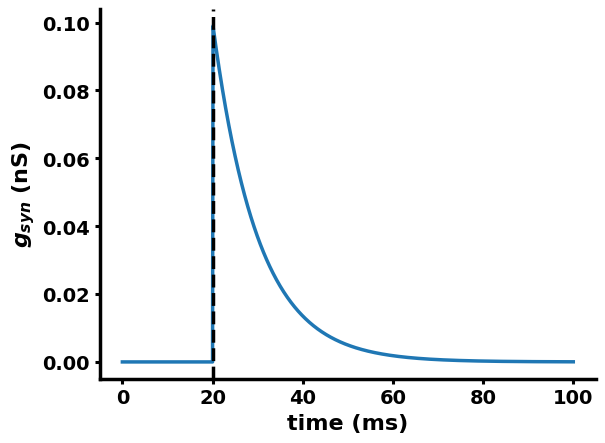

In [4]:
# Simulation parameters
T = 100  # ms
dt = 0.1  # ms
steps = int(T/dt)
t = np.linspace(0, T, steps+1)

ts = 20  # ms
tau = 10  # ms
gsyn_bar = 0.1  # nS

gsyn = gsyn_bar*np.exp(-(t-ts)/tau)*np.heaviside(t-ts,0)

plt.figure()
plt.plot(t, gsyn)
plt.axvline(x=ts, linestyle='--', color='k')
plt.xlabel('time (ms)')
plt.ylabel(r'$g_{syn}$ (nS)')
plt.show()

### Alpha function or Alpha synapse

\begin{equation}
g_{syn}(t) = \bar{g}_{syn} \frac{t-t_s}{\tau}\text{exp} \left( 1 -\frac{t-t_s}{\tau}\right)\mathcal{H}(t-t_s)
\end{equation}

where $t_s$ denotes the time of the arrival of a presynaptic spike, and $\mathcal{H}(\cdot)$ denotes the Heaviside function. The peak of this synapse is observed at $t_{peak}=t_s + \tau$.

<details>
<summary><font color='green'>Click to see the analytical derivation</font></summary>

To find the maximum of any function, we calculate its derivative and we set it to zero. The $t_{peak}$ is the time at which the derivative is zero, i.e., the $g_{syn}(t)$ is maximum.

\begin{align}
\frac{dg_{syn}}{dt} &\stackrel{\text{set}}{=} 0 \\
\bar{g}_{syn} \frac{1}{\tau} \text{exp} \left( -\frac{t_{peak}-t_s}{\tau}\right) - \bar{g}_{syn} \frac{t_{peak}-t_s}{\tau} \text{exp} \left( -\frac{t_{peak}-t_s}{\tau}\right) \frac{1}{\tau} &= 0
\end{align}

Notice that $\bar{g}_{syn}$ and $\text{exp} \left( -\frac{t_{peak}-t_s}{\tau}\right)$ are nonzero values. So, they can be removed from the equation.

\begin{align}
\frac{1}{\tau} - \frac{t_{peak}-t_s}{\tau} \frac{1}{\tau} &= 0 \\
\frac{1}{\tau} &= \frac{t_{peak}-t_s}{\tau} \frac{1}{\tau}
\end{align}

and by removing the $\frac{1}{\tau}$ from both sides and solving for $t_{peak}$ we obtain:

\begin{align}
t_{peak} &= t_s + \tau
\end{align}

</details>

Let's simulate the alpha synapse!

In [5]:
def alpha_synapse(t, tau, gbar=1):
  """
  The alpha function.

  ---
  Args:
    t : float or numpy.ndarray
      A specific time point or a time vector.
    tau: float
      The time constant of the synapse. The value must be positive.
    gbar : float
      The maximum conductance of the synapse. A positive value. Default is 1.

  ---
  Returns:
    float or numpy.ndarray
      The conductance.
  """
  return gbar*((t-ts)/tau)*np.exp(1-(t-ts)/tau)*np.heaviside(t-ts,0)

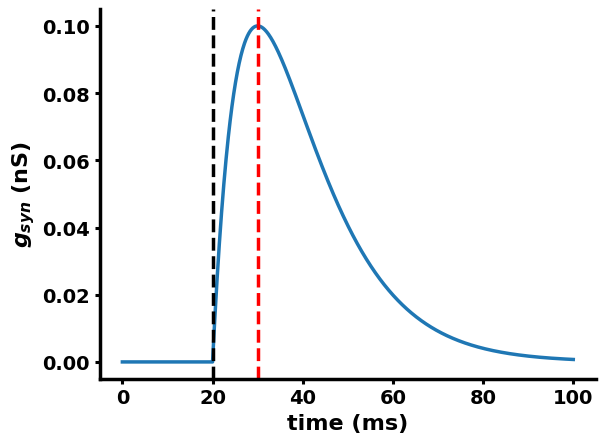

In [8]:
# Simulation parameters
T = 100  # ms
dt = 0.1  # ms
steps = int(T/dt)
t = np.linspace(0, T, steps+1)

ts = 20  # ms
tau = 10  # ms
gsyn_bar = 0.1  # nS

t_peak = ts + tau
gsyn = alpha_synapse(t, tau, gsyn_bar)

plt.figure()
plt.plot(t, gsyn)
plt.axvline(x=ts, linestyle='--', color='k')
plt.axvline(x=ts+tau, linestyle='--', color='r')
plt.xlabel('time (ms)')
plt.ylabel(r'$g_{syn}$ (nS)')
plt.show()

### Dual (doubple) exponential

\begin{equation}
g_{syn}(t) = \bar{g}_{syn} f \left( \text{exp} \left( -\frac{t-t_s}{\tau_d} \right) - \text{exp} \left( -\frac{t-t_s}{\tau_r} \right) \right)\mathcal{H}(t-t_s)
\end{equation}

where $t_s$ denotes the time of the arrival of a presynaptic spike, $\tau_r$, $\tau_d$ are the rise and decay time constants, respectively, and $\mathcal{H}(\cdot)$ denotes the Heaviside function. The dual exponential is needed when the rise and fall times must be set independently, and $\tau_d > \tau_r$. If $\tau_d = \tau_r$ then the dual exponential becomes the alpha function. The $f$ is a normalization factor to bound $g_{syn}(t) \in [0, \bar{g}_{syn}]$ and is equal to:

\begin{equation}
f = \frac{1}{\text{exp} \left( -\frac{t_{peak}-t_s}{\tau_d} \right) - \text{exp} \left( -\frac{t_{peak}-t_s}{\tau_r} \right)}
\end{equation}

The dual exponential function reaches its maximum value at

\begin{equation}
t_{peak} = t_s + \frac{\tau_d\tau_r}{\tau_d - \tau_r} \text{ln} \left( \frac{\tau_d}{\tau_r} \right)
\end{equation}

<details>
<summary><font color='green'>Click to see the analytical derivation</font></summary>

To find the maximum of any function, we calculate its derivative and we set it to zero. The $t_{peak}$ is the time at which the derivative is zero, i.e., the $g_{syn}(t)$ is maximum.

\begin{align}
\frac{dg_{syn}}{dt} &\stackrel{\text{set}}{=} 0 \\
\bar{g}_{syn} f \left( -\frac{1}{\tau_d}\text{exp} \left( -\frac{t_{peak}-t_s}{\tau_d} \right) + \frac{1}{\tau_r} \text{exp} \left( -\frac{t_{peak}-t_s}{\tau_r} \right)\right) &= 0
\end{align}

Notice that $\bar{g}_{syn}$ and $f$ are nonzero values. So, they can be removed from the equation.

\begin{align}
-\frac{1}{\tau_d} \text{exp} \left( -\frac{t_{peak}-t_s}{\tau_d} \right) + \frac{1}{\tau_r} \text{exp} \left( -\frac{t_{peak}-t_s}{\tau_r} \right) &= 0 \\
\frac{1}{\tau_d} \text{exp} \left( -\frac{t_{peak}-t_s}{\tau_d} \right)  &= \frac{1}{\tau_r} \text{exp} \left( -\frac{t_{peak}-t_s}{\tau_r} \right) \\
\text{exp} \left( -\frac{t_{peak}-t_s}{\tau_d} \right) \text{exp} \left( \frac{t_{peak}-t_s}{\tau_r} \right) &= \frac{\tau_d}{\tau_r} \\
\text{exp} \left( -\frac{t_{peak}-t_s}{\tau_d} + \frac{t_{peak}-t_s}{\tau_r} \right) &= \frac{\tau_d}{\tau_r} \\
\end{align}

We use the logarithm for both sides to remove the exponent:

\begin{align}
-\frac{t_{peak}-t_s}{\tau_d} + \frac{t_{peak}-t_s}{\tau_r} &= \text{ln} \left( \frac{\tau_d}{\tau_r} \right)\\
\frac{(\tau_d - \tau_r)(t_{peak}-t_s)}{\tau_d\tau_r} &= \text{ln} \left( \frac{\tau_d}{\tau_r} \right)\\
t_{peak}-t_s &= \frac{\tau_d\tau_r}{\tau_d-\tau_r}\text{ln} \left( \frac{\tau_d}{\tau_r} \right)\\
t_{peak} &= t_s + \frac{\tau_d\tau_r}{\tau_d-\tau_r}\text{ln} \left( \frac{\tau_d}{\tau_r} \right)\\
\end{align}

where we have used the $\frac{1}{\text{exp}(-\alpha)}=\text{exp}(\alpha)$, $\text{exp}(\alpha) + \text{exp}(\beta) = \text{exp}(\alpha + \beta)$, and the $\text{ln}(\text{exp}(\alpha)) = \alpha$.

</details>

Let's simulate the dual exponential synapse!

In [9]:
def dual_exp_synapse(t, tau_rise, tau_decay, gbar=1):
  """
  The alpha function.

  ---
  Args:
    t : float or numpy.ndarray
      A specific time point or a time vector.
    tau_rise: float
      The rise time constant of the synapse. The value must be positive.
    tau_decay: float
      The decay time constant of the synapse. The value must be positive and
      greater than tau_rise, tau_decay > tau_rise.
    gbar : float
      The maximum conductance of the synapse. A positive value. Default is 1.

  ---
  Returns:
    float or numpy.ndarray
      The conductance.
  """
  return gbar*(np.exp(-(t-ts)/tau_d) - np.exp(-(t-ts)/tau_r))*np.heaviside(t-ts,0)

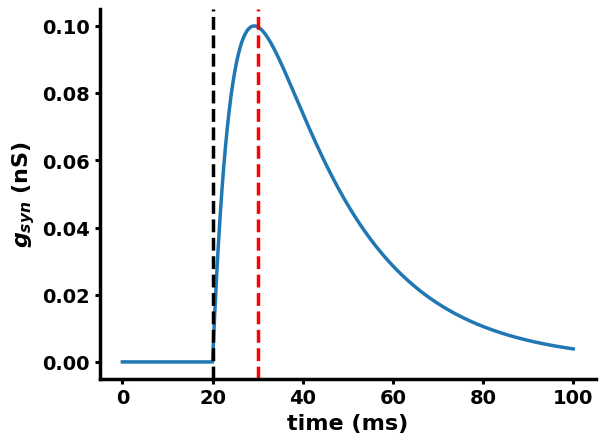

In [10]:
# Simulation parameters
T = 100  # ms
dt = 0.1  # ms
steps = int(T/dt)
t = np.linspace(0, T, steps+1)

ts = 20  # ms
tau_r = 5  # ms
tau_d = 20  # ms
gsyn_bar = 0.1  # nS

# time when g is max
t_peak = (tau_d * tau_r) / (tau_d - tau_r) * np.log(tau_d/tau_r) + ts
# The max g
gsyn_peak = dual_exp_synapse(t_peak, tau_r, tau_d)
# The normalized conductance
gsyn = dual_exp_synapse(t, tau_r, tau_d, gsyn_bar) / gsyn_peak

plt.figure()
plt.plot(t, gsyn)
plt.axvline(x=ts, linestyle='--', color='k')
plt.axvline(x=ts+tau, linestyle='--', color='r')
plt.xlabel('time (ms)')
plt.ylabel(r'$g_{syn}$ (nS)')
plt.show()